In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data procssing
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# image processing
from PIL import Image
from skimage import io, exposure
import cv2

# dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# model building
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

np.set_printoptions(suppress=True)

work_dir = '/content/drive/My Drive/Projects/Lung Cancer Detection'
os.chdir(work_dir)

# Preprocessing - Sample Pictures

In [ ]:
def display_images_from_folders(folder_names, main_folder):
   # setting the names of sample pictures
    folder_names_dict = {
        'normal': 'normal_photo',
        folder_names[1]: 'adeno_cancer',
        folder_names[2]: 'large_cancer',
        folder_names[3]: 'squamos_cancer'
    }

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))


    for i, folder_name in enumerate(folder_names):

        data_folder = os.path.join(main_folder + '/train', folder_name)

        images = os.listdir(data_folder)
        if len(images) > 0:
            image_path = os.path.join(data_folder, images[0])
            image = Image.open(image_path)
            ax = axs[i // 2, i % 2]
            ax.imshow(image, cmap='gray')
            ax.set_title(folder_names_dict[folder_name])
            ax.axis('off')

    plt.show()

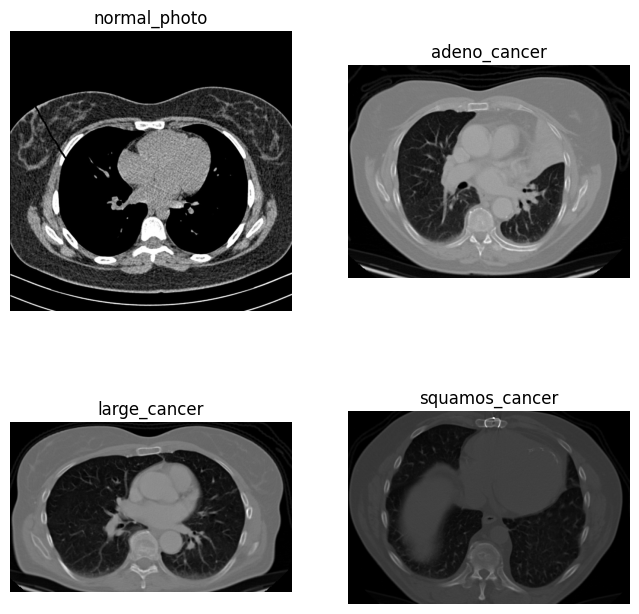

In [ ]:
folders = ['normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
           'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_images_from_folders(folders, 'Data')

# Preprocessing - Number of images

In [ ]:
data_type_list = []
cancer_type_list = []

for datatype in os.listdir('Data'):
    type_path = os.path.join('Data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        for img in os.listdir(folder_path):
            data_type_list.append(datatype)
            cancer_type_list.append(cat[:5])

image_num = pd.crosstab(data_type_list, cancer_type_list,
                        rownames=['data type'],
                        colnames=['cancer type'],
                        margins=True)
image_num

cancer type,adeno,large,norma,squam,All
data type,,,,,
test,120,51,54,90,315
train,195,115,148,155,613
valid,23,21,13,15,72
All,338,187,215,260,1000


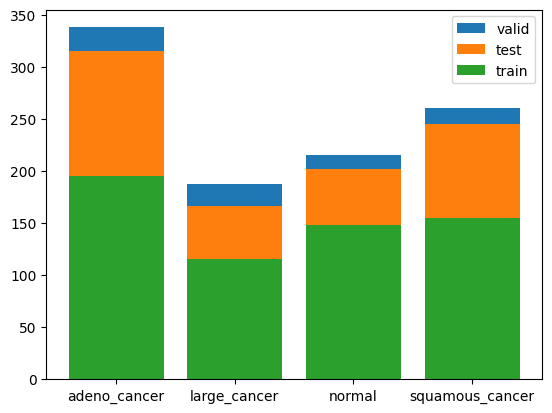

In [ ]:
image_type = ['adeno_cancer', 'large_cancer', 'normal', 'squamous_cancer']
plt.bar(image_type, image_num.iloc[-1, :-1])
plt.bar(image_type, image_num.iloc[0, :-1]+image_num.iloc[1, :-1])
plt.bar(image_type, image_num.iloc[1, :-1])
plt.legend(['valid', 'test', 'train'])
plt.show()

# Preprocessing - Image Brightness

## Pixel brightness

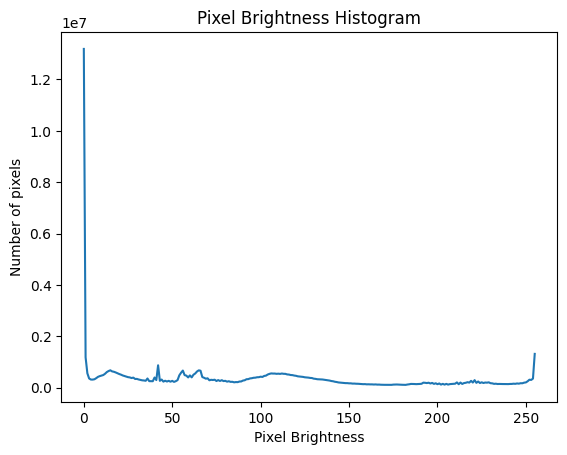

In [ ]:
all_pixel_values = []

for cat in os.listdir('Data/train'):
    folder_path = os.path.join('Data/train', cat)
    for img in os.listdir(folder_path):
        image_path = os.path.join(folder_path, img)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        pixel_values = image.flatten()
        all_pixel_values.extend(pixel_values)

histogram = cv2.calcHist([np.array(all_pixel_values)], [0], None, [256], [0, 256])

plt.figure()
plt.title('Pixel Brightness Histogram')
plt.xlabel('Pixel Brightness')
plt.ylabel('Number of pixels')
plt.plot(histogram)
plt.show()

As we can see, most of the pixels in the train folder are black, which is not surprising. We can also notice many shades of gray in the pictures.

## Whole image brightness

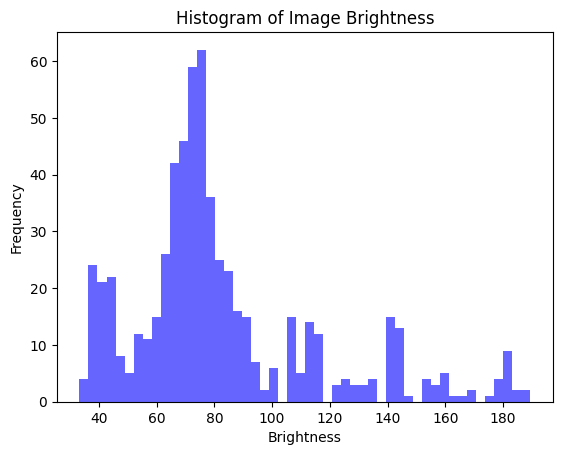

In [ ]:
def calculate_brightness(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = gray_image.mean()
    return brightness

brightness_list = []

for cat in os.listdir('Data/train'):
    folder_path = os.path.join('Data/train', cat)
    for img in os.listdir(folder_path):
        image_path = os.path.join(folder_path, img)
        brightness = calculate_brightness(image_path)
        brightness_list.append(brightness)

plt.hist(brightness_list, bins=50, alpha=0.6, color='b')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Histogram of Image Brightness')
plt.show()

## CLAHE filter

In [ ]:
os.mkdir('filtered_data')

for datatype in os.listdir('Data'):
    os.mkdir(os.path.join('filtered_data', datatype))

for datatype in os.listdir('Data'):
    old_type_path = os.path.join('Data', datatype)
    new_type_path = os.path.join('filtered_data', datatype)
    for cat in os.listdir(old_type_path):
        new_folder_path = os.path.join(new_type_path, cat)
        os.mkdir(new_folder_path)

In [ ]:
for datatype in os.listdir('Data'):
    type_path = os.path.join('Data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        for img in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img)

            image = io.imread(image_path, as_gray=True)

            equalized_image = exposure.equalize_adapthist(image, clip_limit=0.02)

            equalized_image = (equalized_image * 255).astype(np.uint8)

            new_path = image_path.replace('Data', 'filtered_data')
            io.imsave(new_path, equalized_image)

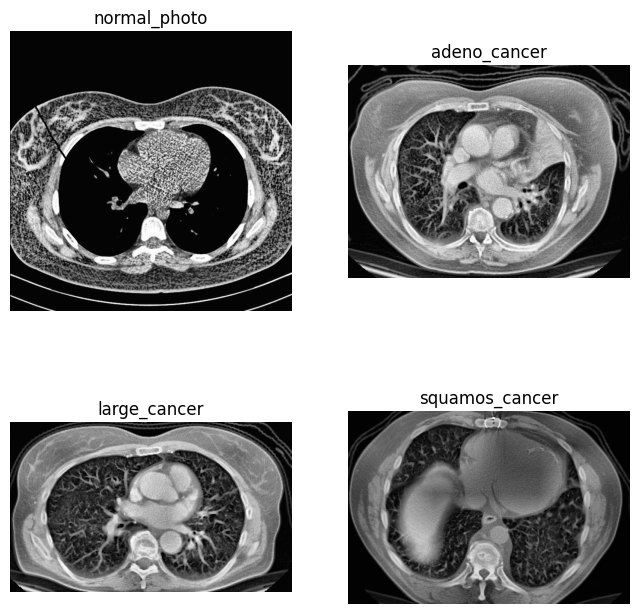

In [ ]:
folders = ['normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
           'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_images_from_folders(folders, 'filtered_data')


# Preprocessing - Image size

## Choosing the final size

In [ ]:
# creating of data frame with height, width and path of image (train set)
# empty lists
img_height_list = []
img_width_list = []
path_list = []

# uploading size and path of all images in train data
for cat in os.listdir('filtered_data/train'):
    folder_path = os.path.join('filtered_data/train', cat)
    for img in os.listdir(folder_path):
        image_path = os.path.join(folder_path, img)
        path_list.append(image_path)
        image = Image.open(image_path)
        img_width_list.append(image.size[0])
        img_height_list.append(image.size[1])

# creating of data frame
img_sizes_dic = {"width": img_width_list, "height": img_height_list, "path": path_list}
img_sizes_df = pd.DataFrame(img_sizes_dic)
img_sizes_df.head()

,width,height,path
0,630,626,filtered_data/train/normal/2 - Copy.png
1,371,251,filtered_data/train/normal/10 - Copy.png
2,441,341,filtered_data/train/normal/11 - Copy (2) - Cop...
3,371,251,filtered_data/train/normal/10 - Copy (2).png
4,371,251,filtered_data/train/normal/10 (2) - Copy.png


In [ ]:
# checking sizes of images
img_sizes_df.describe()

,width,height
count,613.000000,613.000000
mean,435.836868,303.314845
std,133.486381,106.283336
min,168.000000,110.000000
25%,377.000000,243.000000
50%,410.000000,273.000000
75%,438.000000,316.000000
max,1200.000000,874.000000


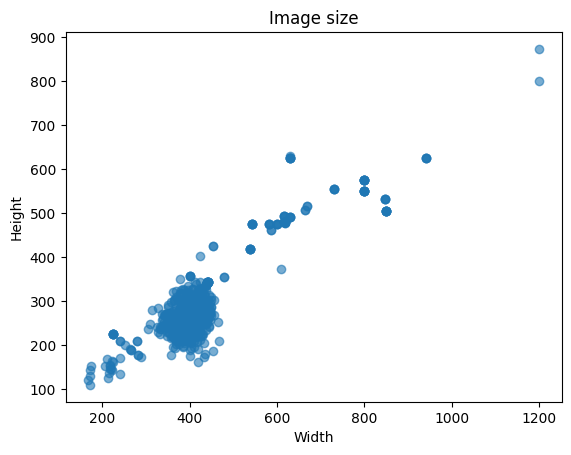

In [ ]:
# by summary statistics we see that images have different size so chart was made
plt.scatter(img_sizes_df['width'], img_sizes_df['height'], alpha=0.6)
plt.title("Image size")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

Most of images has similar size, but some of them is extremly bigger. To make the same size of images different methods will be applied for these two groups. For first group of images, which have standard size, zero padding will be used. For other images firstly scaling will be aplied and after that - zero padding. Scaling will be aplied in the way to keep the proportions and to evoid thedeformation of images.

In [ ]:
# counting of size of images for next analisis
# on the chart we see that all images with width bigger than 500 have outlire size
target_width = max(img_sizes_df[img_sizes_df['width'] < 500]['width'])

# we also see that there is no so many images with size bigger than 400
target_height = max(img_sizes_df[img_sizes_df['height'] < 400]['height'])

print('Final size of images:', target_width, '*', target_height)

Final size of images: 478 * 374


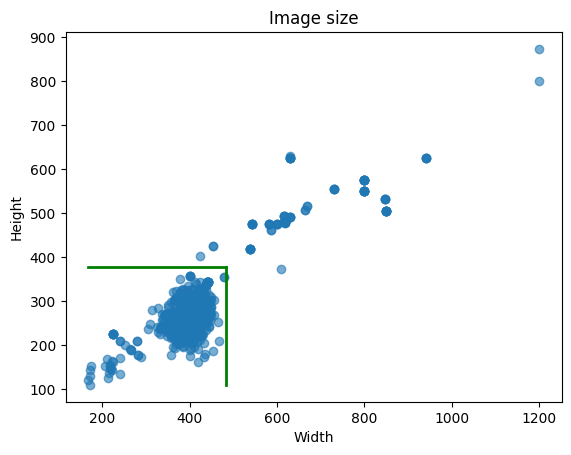

In [ ]:
# the chart
plt.scatter(img_sizes_df['width'], img_sizes_df['height'], alpha=0.6)
plt.plot([target_width+5, target_width+5], [110, target_height+5], lw=2, color="green")
plt.plot([168, target_width+5], [target_height+5, target_height+5], lw=2, color="green")
plt.title("Image size")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

## Spliting images by size

In [ ]:
# creating of data frame with height, width and path of image
# empty lists
img_width_list = []
img_height_list = []
path_list = []
data_type_list = []
cancer_type_list = []

# uploading size and path of all images in train data
for datatype in os.listdir('filtered_data'):
    type_path = os.path.join('filtered_data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        for img in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img)
            path_list.append(image_path)
            image = Image.open(image_path)
            img_width_list.append(image.size[0])
            img_height_list.append(image.size[1])
            data_type_list.append(datatype)
            cancer_type_list.append(cat)

# creating of data frame
img_sizes_dic = {"width": img_width_list, "height": img_height_list,
                      "data_type": data_type_list,
                      "cancer_type": cancer_type_list, "path": path_list}
img_sizes_df = pd.DataFrame(img_sizes_dic)
img_sizes_df.head()

,width,height,data_type,cancer_type,path
0,630,626,train,normal,filtered_data/train/normal/2 - Copy.png
1,371,251,train,normal,filtered_data/train/normal/10 - Copy.png
2,441,341,train,normal,filtered_data/train/normal/11 - Copy (2) - Cop...
3,371,251,train,normal,filtered_data/train/normal/10 - Copy (2).png
4,371,251,train,normal,filtered_data/train/normal/10 (2) - Copy.png


In [ ]:
# the pathes to images which needs zero padding only
img_sizes_df_zp = img_sizes_df[(img_sizes_df['width'] <= target_width) & (img_sizes_df['height'] <= target_height)]

print("Zero padding will be applied for",
      round(len(img_sizes_df_zp)/len(img_sizes_df)*100, 2),
      "% of the images")

img_sizes_df_zp['path'].head()

Zero padding will be applied for 80.9 % of the images


1             filtered_data/train/normal/10 - Copy.png
2    filtered_data/train/normal/11 - Copy (2) - Cop...
3         filtered_data/train/normal/10 - Copy (2).png
4         filtered_data/train/normal/10 (2) - Copy.png
5             filtered_data/train/normal/11 - Copy.png
Name: path, dtype: object

In [ ]:
# the pathes to images which needs scaling and zero padding
img_sizes_df_sc_zp = img_sizes_df[(img_sizes_df['width'] > target_width) | (img_sizes_df['height'] > target_height)]

print("Scalind and Zero Padding will be applied for",
      round(len(img_sizes_df_sc_zp)/len(img_sizes_df)*100, 2),
      "% of the images")

img_sizes_df_sc_zp['path'].head()

Scalind and Zero Padding will be applied for 19.1 % of the images


0               filtered_data/train/normal/2 - Copy.png
6                 filtered_data/train/normal/12 (2).png
11                    filtered_data/train/normal/12.png
13         filtered_data/train/normal/12 - Copy (2).png
14    filtered_data/train/normal/13 - Copy (2) - Cop...
Name: path, dtype: object

In [ ]:
# info about which part of all images needs zero padding only
for datatype in ['train', 'test', 'valid']:
  img_sizes_df_zp_type = img_sizes_df_zp[img_sizes_df_zp['data_type']==datatype]
  img_sizes_df_type = (img_sizes_df[img_sizes_df['data_type']==datatype])
  print("Zero padding will be applied for",
      round(len(img_sizes_df_zp_type)/len(img_sizes_df_type)*100, 2),
      "% of the images of", datatype, "dataset")

Zero padding will be applied for 84.5 % of the images of train dataset
Zero padding will be applied for 73.65 % of the images of test dataset
Zero padding will be applied for 81.94 % of the images of valid dataset


## Folders for new images

In [ ]:
os.mkdir('new_data')

for datatype in os.listdir('filtered_data'):
    os.mkdir(os.path.join('new_data', datatype))

In [ ]:
for datatype in os.listdir('filtered_data'):
    old_type_path = os.path.join('filtered_data', datatype)
    new_type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(old_type_path):
        new_folder_path = os.path.join(new_type_path, cat)
        os.mkdir(new_folder_path)

## Zero padding only

In [ ]:
for path in img_sizes_df_zp['path']:
    image = Image.open(path)
    width, height = image.size

    padding_width = max(0, target_width - width)
    padding_height = max(0, target_height - height)

    new_width = width + padding_width
    new_height = height + padding_height

    #the black outline is added to the old images

    padded_image = Image.new(image.mode, (new_width, new_height), (0))
    offset = ((new_width - width) // 2, (new_height - height) // 2)
    padded_image.paste(image, offset)

    # saving image in new folder

    # saving image in new folder
    new_path = path.replace('filtered_data', 'new_data')

    padded_image.save(new_path)

## Scaling and zero padding

In [ ]:
for path in img_sizes_df_sc_zp['path']:
    image = Image.open(path)
    width, height = image.size

    # scaling

    if target_width/width <= target_height/height:
        a = target_width/width
        scaled_image = image.resize((target_width, int(height*a)))
    else:
        a = target_height/height
        scaled_image = image.resize((int(width*a), target_height))

    width, height = scaled_image.size

    # zero padding
    padding_width = max(0, target_width - width)
    padding_height = max(0, target_height - height)

    new_width = width + padding_width
    new_height = height + padding_height

    # the black outline is added to the old images
    padded_image = Image.new(scaled_image.mode, (new_width, new_height), 0)
    offset = ((new_width - width) // 2, (new_height - height) // 2)
    padded_image.paste(scaled_image, offset)


    # saving image in new folder

    new_path = path.replace('filtered_data', 'new_data')

    padded_image.save(new_path)

In [ ]:
# checking size of the new images

# creating of data frame with height, width and path of image
# empty lists
img_width_list = []
img_height_list = []

# uploading size and path of all images in train data
for datatype in os.listdir('new_data'):
    type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        for img in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img)
            image = Image.open(image_path)
            img_width_list.append(image.size[0])
            img_height_list.append(image.size[1])

image.close()

# creating of data frame
img_sizes_dic = {"width": img_width_list, "height": img_height_list}
img_sizes_df = pd.DataFrame(img_sizes_dic)
img_sizes_df.describe()

,width,height
count,1000.0,1000.0
mean,478.0,374.0
std,0.0,0.0
min,478.0,374.0
25%,478.0,374.0
50%,478.0,374.0
75%,478.0,374.0
max,478.0,374.0


Standard deviation is equel to 0, all images has the same size

# Preprocessing - Name of folders

In [ ]:
# checking name of folders

for datatype in os.listdir('new_data'):
    type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        print(f'new_data/{datatype}/{cat}')

new_data/train/normal
new_data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
new_data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
new_data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
new_data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
new_data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
new_data/valid/normal
new_data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
new_data/test/large.cell.carcinoma
new_data/test/adenocarcinoma
new_data/test/normal
new_data/test/squamous.cell.carcinoma


In [ ]:
# folders with cancer type have different names
# changing name of folders

rename = {
    'adenocarcinoma': 'adeno_cancer',
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'adeno_cancer',
    'large.cell.carcinoma': 'large_cancer',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large_cancer',
    'normal': 'normal',
    'squamous.cell.carcinoma': 'squamous_cancer',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous_cancer'
}

for datatype in os.listdir('new_data'):
    type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(type_path):
        if cat in rename:
            old_path = os.path.join(type_path, cat)
            new_path = os.path.join(type_path, rename[cat])
            os.rename(old_path, new_path)



In [ ]:
# checking name of folders

for datatype in os.listdir('new_data'):
    type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        print(f'new_data/{datatype}/{cat}')


new_data/train/normal
new_data/train/large_cancer
new_data/train/squamous_cancer
new_data/train/adeno_cancer
new_data/valid/large_cancer
new_data/valid/adeno_cancer
new_data/valid/normal
new_data/valid/squamous_cancer
new_data/test/large_cancer
new_data/test/adeno_cancer
new_data/test/normal
new_data/test/squamous_cancer


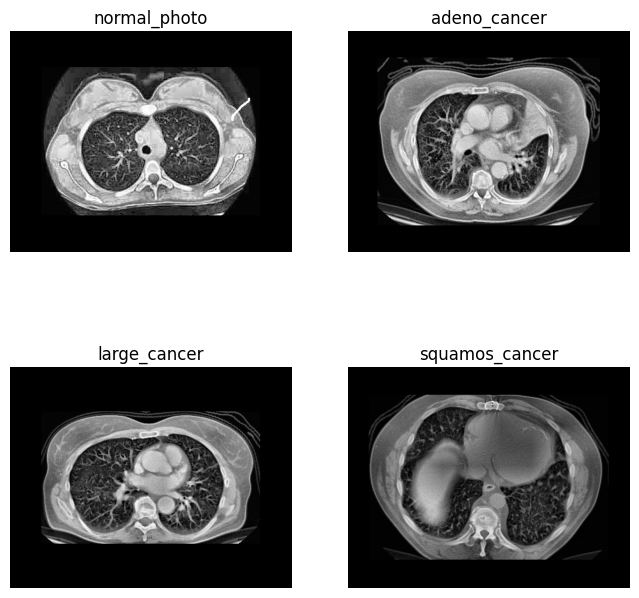

In [ ]:
folders = ['normal', 'adeno_cancer', 'large_cancer', 'squamous_cancer']

display_images_from_folders(folders, 'new_data')

# Creating a dataframe from images

In [ ]:
data_type_list = []
cancer_type_list = []
flat_data_list = []

for datatype in os.listdir('new_data'):
    type_path = os.path.join('new_data', datatype)
    for cat in os.listdir(type_path):
        folder_path = os.path.join(type_path, cat)
        for img in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img)
            image = Image.open(image_path)
            image = image.convert('L')
            img_array = np.asarray(image)

            flat_data_list.append(img_array.flatten())
            cancer_type_list.append(cat)
            data_type_list.append(datatype)

# creating of data frame
df = pd.DataFrame(np.asarray(flat_data_list))

In [ ]:
df['cancer_type'] = cancer_type_list
df['data_type'] = data_type_list
df

,0,1,2,3,4,5,6,7,8,9,...,178764,178765,178766,178767,178768,178769,178770,178771,cancer_type,data_type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,squamous_cancer,test
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,squamous_cancer,test
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,squamous_cancer,test
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,squamous_cancer,test


# Dimensionality reduction

In [ ]:
df_train = df[df['data_type']=='train']
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178764,178765,178766,178767,178768,178769,178770,178771,cancer_type,data_type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,normal,train


In [ ]:
# standardization of train data
std_scaler = StandardScaler()

df_train_std = pd.DataFrame(std_scaler.fit_transform(df[df['data_type'] == 'train'].iloc[:,:-2]),
                        columns=df.columns[:-2])

df_train_std.head()


,0,1,2,3,4,5,6,7,8,9,...,178762,178763,178764,178765,178766,178767,178768,178769,178770,178771
0,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
1,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
2,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
3,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
4,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0


In [ ]:
# applying fitted standardization on all data
df_std = pd.DataFrame(std_scaler.transform(df.iloc[:, :-2]),
                            columns=df.columns[:-2])

df_std.head()


,0,1,2,3,4,5,6,7,8,9,...,178762,178763,178764,178765,178766,178767,178768,178769,178770,178771
0,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
1,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
2,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
3,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0
4,-0.081044,-0.081044,-0.086432,-0.08185,-0.08185,-0.08185,-0.08185,-0.082173,-0.082173,-0.082173,...,-0.081847,-0.081847,-0.081847,-0.081525,-0.081525,-0.081525,-0.081525,-0.057213,0.0,0.0


## t-SNE

In [ ]:
tsne = TSNE(perplexity=5)
results_sne = tsne.fit_transform(df_train_std)

coordinates = pd.DataFrame(results_sne,
                           columns=[f'Coordinate {i}' for i in range(1, results_sne.shape[1]+1)])
coordinates['cancer'] = df[df['data_type'] == 'train'].reset_index()['cancer_type']
coordinates.head()


,Coordinate 1,Coordinate 2,cancer
0,-91.221710,-50.743317,normal
1,88.381241,23.779156,normal
2,-93.428452,-49.741497,normal
3,-87.027321,-48.854324,normal
4,87.309731,25.298199,normal


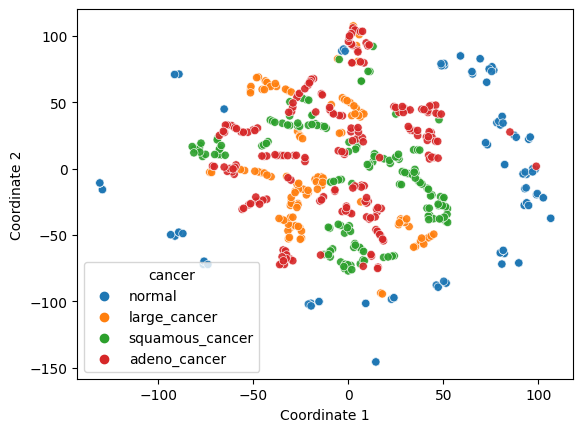

In [ ]:
sns.scatterplot(x='Coordinate 1', y='Coordinate 2', data=coordinates,
                hue='cancer',
                alpha=0.9)
plt.show()


## PCA

In [ ]:
pca = PCA()
pca.fit(df_train_std)

PCA()

In [ ]:
p = 1
while sum(pca.explained_variance_ratio_[:p])*100 < 85:
    p+=1
print(
    f'For further analysis, {p} principal components were taken, which explain {round(sum(pca.explained_variance_ratio_[:p])*100, 2)}% of information')


For further analysis, 58 principal components were taken, which explain 85.14% of information


In [ ]:
eigenvectors = pca.components_[:p]

eigenvectors

array([[ 0.00057655,  0.00057655,  0.00068986, ...,  0.00048974,
         0.        ,  0.        ],
       [ 0.00186819,  0.00186819,  0.00199355, ...,  0.00132013,
        -0.        , -0.        ],
       [-0.00151252, -0.00151252, -0.00091912, ..., -0.00030217,
        -0.        , -0.        ],
       ...,
       [-0.00144114, -0.00144114,  0.00069443, ...,  0.00144436,
         0.        ,  0.        ],
       [-0.00200029, -0.00200029, -0.00115177, ..., -0.00032927,
        -0.        , -0.        ],
       [-0.00141324, -0.00141324, -0.00142215, ..., -0.00090385,
        -0.        , -0.        ]])

In [ ]:
# applying od eigenvectors on all standardizated data
reduced_data = np.dot(df_std, eigenvectors.T)
reduced_df = pd.DataFrame(reduced_data)

reduced_df['cancer_type'] = df['cancer_type']
reduced_df['data_type'] = df['data_type']

reduced_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,cancer_type,data_type
0,-145.781899,-38.496401,89.594880,-140.564209,76.438703,33.702205,80.035570,-30.188372,23.504142,46.270633,...,-8.200978,1.021922,-21.405012,-10.347702,1.065175,3.516955,-6.199935,1.414955,normal,train
1,407.575940,-24.065177,-212.324449,-167.417828,-167.886639,55.294645,-42.632799,-141.737902,113.487230,-14.188752,...,-4.067496,-11.662054,5.934348,-1.078900,-3.911860,-1.399918,-0.497785,-2.184795,normal,train
2,-145.754107,-37.510091,90.195293,-140.928995,75.905379,34.123619,80.087831,-30.437811,23.494478,47.055281,...,-8.320589,0.999423,-21.371905,-9.199641,0.104196,2.913903,-4.753332,1.828752,normal,train
3,-145.847654,-36.367174,89.183317,-140.242302,76.169063,32.678128,79.578537,-30.754090,24.372065,46.934280,...,-8.673416,-0.280994,-20.816970,-9.713729,0.444211,2.952497,-6.051822,0.198592,normal,train
4,395.160567,-17.091994,-217.818433,-152.088272,-164.216974,60.380219,-40.713207,-138.810431,121.624647,-17.216508,...,-4.118661,-11.285277,6.076697,-1.048094,-4.945640,-0.646350,0.048901,-2.431590,normal,train


# Creating models

In [ ]:
train_features = reduced_df[reduced_df['data_type'] == 'train'].iloc[:,:-2]
train_labels = np.array(reduced_df[reduced_df['data_type'] == 'train'].iloc[:, -2:-1]).ravel()

test_features = reduced_df[reduced_df['data_type'] == 'test'].iloc[:, :-2]
test_labels = np.array(reduced_df[reduced_df['data_type'] == 'test'].iloc[:, -2:-1]).ravel()

valid_features = reduced_df[reduced_df['data_type'] == 'valid'].iloc[:, :-2]
valid_labels = np.array(reduced_df[reduced_df['data_type'] == 'valid'].iloc[:, -2:-1]).ravel()

In [ ]:
# function which print result of defined classification function

def pred_result(function, test_features=test_features, test_labels=test_labels):

    function.fit(train_features, train_labels)

    y_train_pred = function.predict(train_features)
    y_test_pred = function.predict(test_features)

    accuracy_train = accuracy_score(train_labels, y_train_pred)
    accuracy_test = accuracy_score(test_labels, y_test_pred)

    print(f"Accuracy to train data: {accuracy_train:.3f}")
    print(f"Accuracy to test data: {accuracy_test:.3f}")

    print("Raport for test data:")
    print(classification_report(test_labels, y_test_pred))

    print("Confusion matrix:")
    print(pd.crosstab(test_labels, y_test_pred,
                    rownames=['empirical values'],
                    colnames=['predicted values'],
                    margins=True))


## KNN

### Default arguments

In [ ]:
knn = KNeighborsClassifier()

pred_result(knn)

Accuracy to train data: 0.935
Accuracy to test data: 0.629
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.57      0.64      0.60       120
   large_cancer       0.74      0.45      0.56        51
         normal       1.00      0.94      0.97        54
squamous_cancer       0.48      0.52      0.50        90

       accuracy                           0.63       315
      macro avg       0.70      0.64      0.66       315
   weighted avg       0.65      0.63      0.63       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                77             8       0               35  120
large_cancer                12            23       0               16   51
normal                       3             0      51                0   54
squamous_cancer             43             0       0               

### Grid search and modyfing the 'n_neighbors' parameter

In [ ]:
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)

grid_search_knn.fit(train_features, train_labels)

knn_best_estimator = grid_search_knn.best_estimator_
print(knn_best_estimator)

pred_result(knn_best_estimator)

KNeighborsClassifier(n_neighbors=2, weights='distance')
Accuracy to train data: 0.998
Accuracy to test data: 0.673
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.61      0.64      0.63       120
   large_cancer       0.81      0.59      0.68        51
         normal       1.00      0.91      0.95        54
squamous_cancer       0.54      0.62      0.58        90

       accuracy                           0.67       315
      macro avg       0.74      0.69      0.71       315
   weighted avg       0.69      0.67      0.68       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                77             6       0               37  120
large_cancer                12            30       0                9   51
normal                       3             1      49                1   54
squamous_ca

In [ ]:
# modification of neighbors number only

i = 1
while i < 16:
  knn = KNeighborsClassifier(n_neighbors=i, p = 1, metric='manhattan')
  knn.fit(train_features, train_labels)

  # train
  y_train_pred = knn.predict(train_features)
  accuracy_train = accuracy_score(train_labels, y_train_pred)
  print(f"Fitting to the train data with 'n_neighbors'={i}: {accuracy_train:.3f}")

  # test
  y_test_pred = knn.predict(test_features)
  accuracy_test = accuracy_score(test_labels, y_test_pred)
  print(f"Fitting to the test data with 'n_neighbors'={i}: {accuracy_test:.3f}")
  print( )
  i+= 1


Fitting to the train data with 'n_neighbors'=1: 0.998
Fitting to the test data with 'n_neighbors'=1: 0.692

Fitting to the train data with 'n_neighbors'=2: 0.966
Fitting to the test data with 'n_neighbors'=2: 0.692

Fitting to the train data with 'n_neighbors'=3: 0.969
Fitting to the test data with 'n_neighbors'=3: 0.651

Fitting to the train data with 'n_neighbors'=4: 0.949
Fitting to the test data with 'n_neighbors'=4: 0.635

Fitting to the train data with 'n_neighbors'=5: 0.946
Fitting to the test data with 'n_neighbors'=5: 0.619

Fitting to the train data with 'n_neighbors'=6: 0.931
Fitting to the test data with 'n_neighbors'=6: 0.616

Fitting to the train data with 'n_neighbors'=7: 0.930
Fitting to the test data with 'n_neighbors'=7: 0.610

Fitting to the train data with 'n_neighbors'=8: 0.912
Fitting to the test data with 'n_neighbors'=8: 0.613

Fitting to the train data with 'n_neighbors'=9: 0.918
Fitting to the test data with 'n_neighbors'=9: 0.625

Fitting to the train data wi

In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=2, metric='manhattan', p = 1)

pred_result(knn_best)


Accuracy to train data: 0.966
Accuracy to test data: 0.692
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.59      0.82      0.69       120
   large_cancer       0.72      0.55      0.62        51
         normal       1.00      0.87      0.93        54
squamous_cancer       0.71      0.50      0.59        90

       accuracy                           0.69       315
      macro avg       0.76      0.68      0.71       315
   weighted avg       0.72      0.69      0.69       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                98             9       0               13  120
large_cancer                18            28       0                5   51
normal                       6             1      47                0   54
squamous_cancer             44             1       0               

## Random Forest

### Default arguments

In [ ]:
rand_forest = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state = 0)

pred_result(rand_forest)

Accuracy to train data: 0.998
Accuracy to test data: 0.603
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.54      0.75      0.63       120
   large_cancer       0.84      0.31      0.46        51
         normal       0.78      0.96      0.86        54
squamous_cancer       0.51      0.36      0.42        90

       accuracy                           0.60       315
      macro avg       0.67      0.60      0.59       315
   weighted avg       0.62      0.60      0.58       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                90             3       9               18  120
large_cancer                22            16       0               13   51
normal                       2             0      52                0   54
squamous_cancer             52             0       6               

### Grid search and modyfing the 'max_features'and 'max_depth' parameters

In [ ]:
param_grid_rf = {'criterion': ['gini', 'entropy'],
                          'max_depth': np.arange(8, 20, 4),
                          'min_samples_leaf': np.arange(4, 10, 2),
                          'max_features': np.arange(2, 7)}


grid_search_rf = GridSearchCV(rand_forest,
                                       param_grid=param_grid_rf, cv=5)
grid_search_rf.fit(train_features, train_labels)

rf_best_estimator = grid_search_rf.best_estimator_
print(rf_best_estimator)

pred_result(rf_best_estimator)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=3, min_samples_leaf=4,
                       n_estimators=200, random_state=0)
Accuracy to train data: 0.997
Accuracy to test data: 0.581
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.53      0.69      0.60       120
   large_cancer       0.68      0.25      0.37        51
         normal       0.83      0.96      0.89        54
squamous_cancer       0.46      0.39      0.42        90

       accuracy                           0.58       315
      macro avg       0.62      0.57      0.57       315
   weighted avg       0.59      0.58      0.56       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                83             4       9               24  120
large_cancer      

In [ ]:
# modification of the number of features to consider when looking for the best split only
i = 1
while i < 8:
  rand_forest = RandomForestClassifier(n_estimators=200, class_weight='balanced', criterion='entropy',
                                       max_depth=16, max_features=i, min_samples_leaf=4, random_state=0)
  rand_forest.fit(train_features, train_labels)

  # train
  y_train_pred = rand_forest.predict(train_features)
  accuracy_train = accuracy_score(train_labels, y_train_pred)
  print(f"Fitting to the train data with 'max_features'={i}: {accuracy_train:.3f}")

  # test
  y_test_pred = rand_forest.predict(test_features)
  accuracy_test = accuracy_score(test_labels, y_test_pred)
  print(f"Fitting to the test data 'max_features'={i}: {accuracy_test:.3f}")
  print()
  i+= 1

Fitting to the train data with 'max_features'=1: 0.997
Fitting to the test data 'max_features'=1: 0.568

Fitting to the train data with 'max_features'=2: 0.997
Fitting to the test data 'max_features'=2: 0.603

Fitting to the train data with 'max_features'=3: 0.997
Fitting to the test data 'max_features'=3: 0.590

Fitting to the train data with 'max_features'=4: 0.997
Fitting to the test data 'max_features'=4: 0.613

Fitting to the train data with 'max_features'=5: 0.997
Fitting to the test data 'max_features'=5: 0.584

Fitting to the train data with 'max_features'=6: 0.997
Fitting to the test data 'max_features'=6: 0.581

Fitting to the train data with 'max_features'=7: 0.997
Fitting to the test data 'max_features'=7: 0.575



In [ ]:
# modification of the maximum depth of the tree only
i = 15
while i < 21:
  rand_forest = RandomForestClassifier(n_estimators=200, class_weight='balanced', criterion='entropy',
                                       max_depth=i, max_features=3, min_samples_leaf=4, random_state=0)
  rand_forest.fit(train_features, train_labels)

  # train
  y_train_pred = rand_forest.predict(train_features)
  accuracy_train = accuracy_score(train_labels, y_train_pred)
  print(f"Fitting to the train data with 'max_depth'={i}: {accuracy_train:.3f}")

  # test
  y_test_pred = rand_forest.predict(test_features)
  accuracy_test = accuracy_score(test_labels, y_test_pred)
  print(f"Fitting to the test data 'max_depth'={i}: {accuracy_test:.3f}")
  print()
  i+= 1

Fitting to the train data with 'max_depth'=15: 0.997
Fitting to the test data 'max_depth'=15: 0.600

Fitting to the train data with 'max_depth'=16: 0.997
Fitting to the test data 'max_depth'=16: 0.590

Fitting to the train data with 'max_depth'=17: 0.997
Fitting to the test data 'max_depth'=17: 0.594

Fitting to the train data with 'max_depth'=18: 0.997
Fitting to the test data 'max_depth'=18: 0.594

Fitting to the train data with 'max_depth'=19: 0.997
Fitting to the test data 'max_depth'=19: 0.587

Fitting to the train data with 'max_depth'=20: 0.997
Fitting to the test data 'max_depth'=20: 0.587



In [ ]:
rand_forest_best = RandomForestClassifier(n_estimators=200, class_weight='balanced', criterion='entropy',
                                     max_depth=17, max_features=3, min_samples_leaf=4, random_state = 0)
pred_result(rand_forest_best)


Accuracy to train data: 0.997
Accuracy to test data: 0.594
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.54      0.74      0.62       120
   large_cancer       0.81      0.25      0.39        51
         normal       0.83      0.96      0.89        54
squamous_cancer       0.47      0.37      0.41        90

       accuracy                           0.59       315
      macro avg       0.66      0.58      0.58       315
   weighted avg       0.61      0.59      0.57       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                89             2       8               21  120
large_cancer                22            13       0               16   51
normal                       2             0      52                0   54
squamous_cancer             53             1       3               

## SVM

### Default arguments

In [ ]:
svc = SVC(probability=True, class_weight='balanced', random_state = 0)

pred_result(svc)

Accuracy to train data: 0.881
Accuracy to test data: 0.651
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.57      0.78      0.66       120
   large_cancer       0.73      0.37      0.49        51
         normal       1.00      0.94      0.97        54
squamous_cancer       0.55      0.47      0.51        90

       accuracy                           0.65       315
      macro avg       0.71      0.64      0.66       315
   weighted avg       0.67      0.65      0.64       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                93             4       0               23  120
large_cancer                21            19       0               11   51
normal                       3             0      51                0   54
squamous_cancer             45             3       0               

### Grid search

In [ ]:
param_grid_svc = {
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

grid_search_svc = GridSearchCV(svc, param_grid=param_grid_svc, cv=5)
grid_search_svc.fit(train_features, train_labels)

svc_best_estimator = grid_search_svc.best_estimator_
print(svc_best_estimator)

pred_result(svc_best_estimator)

SVC(C=10, class_weight='balanced', probability=True, random_state=0)
Accuracy to train data: 0.987
Accuracy to test data: 0.679
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.60      0.80      0.69       120
   large_cancer       0.66      0.49      0.56        51
         normal       1.00      0.91      0.95        54
squamous_cancer       0.64      0.49      0.55        90

       accuracy                           0.68       315
      macro avg       0.72      0.67      0.69       315
   weighted avg       0.69      0.68      0.67       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                96             6       0               18  120
large_cancer                19            25       0                7   51
normal                       4             1      49                0   5

In [ ]:
svc_best = SVC(C=10, class_weight='balanced', probability=True, random_state=0)

pred_result(svc_best)

Accuracy to train data: 0.987
Accuracy to test data: 0.679
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.60      0.80      0.69       120
   large_cancer       0.66      0.49      0.56        51
         normal       1.00      0.91      0.95        54
squamous_cancer       0.64      0.49      0.55        90

       accuracy                           0.68       315
      macro avg       0.72      0.67      0.69       315
   weighted avg       0.69      0.68      0.67       315

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                96             6       0               18  120
large_cancer                19            25       0                7   51
normal                       4             1      49                0   54
squamous_cancer             40             6       0               

## Compering the result

In [ ]:
print(pd.crosstab(knn_best.predict(test_features), rand_forest_best.predict(test_features),
                  margins=True,
                  rownames=['KNN prediction'],
                  colnames=['Random forest prediction']))
print()

print(pd.crosstab(knn_best.predict(test_features), svc_best.predict(test_features),
                  margins=True,
                  rownames=['KNN prediction'],
                  colnames=['SVC prediction']))
print()

print(pd.crosstab(rand_forest_best.predict(test_features), svc_best.predict(test_features),
                  margins=True,
                  rownames=['Random forest prediction'],
                  colnames=['SVC prediction']))


Random forest prediction  adeno_cancer  large_cancer  normal  squamous_cancer  \
KNN prediction                                                                  
adeno_cancer                       125             4      10               27   
large_cancer                        16            10       0               13   
normal                               0             0      47                0   
squamous_cancer                     25             2       6               30   
All                                166            16      63               70   

Random forest prediction  All  
KNN prediction                 
adeno_cancer              166  
large_cancer               39  
normal                     47  
squamous_cancer            63  
All                       315  

SVC prediction   adeno_cancer  large_cancer  normal  squamous_cancer  All
KNN prediction                                                           
adeno_cancer              122            13       2        

# Ensembles methods

## Voting classifier

### Default arguments

In [ ]:
voting_clr = VotingClassifier(
    estimators=[('knn', knn_best), ('rf', rand_forest_best), ('svc', svc_best)])

pred_result(voting_clr, test_features=valid_features, test_labels=valid_labels)


Accuracy to train data: 0.993
Accuracy to test data: 0.833
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.68      0.91      0.78        23
   large_cancer       0.93      0.67      0.78        21
         normal       1.00      0.77      0.87        13
squamous_cancer       0.94      1.00      0.97        15

       accuracy                           0.83        72
      macro avg       0.89      0.84      0.85        72
   weighted avg       0.86      0.83      0.83        72

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                21             1       0                1   23
large_cancer                 7            14       0                0   21
normal                       3             0      10                0   13
squamous_cancer              0             0       0               

### Modyfing the 'voting' and 'weights' parameters

In [ ]:
# modification of the rule of voting and weights of the models
for j in ['hard', 'soft']:
    for i in [[1,1,1], [1,0,1], [2,1,2], [3,1,2], [2,1,3]]:
        voting_clr = VotingClassifier(
            estimators=[('knn', knn_best), ('rf', rand_forest_best), ('svc', svc_best)], weights=i,
            voting = j)
        voting_clr.fit(train_features, train_labels)

        # train
        y_train_pred = voting_clr.predict(train_features)
        accuracy_train = accuracy_score(train_labels, y_train_pred)
        print(f"Fitting to the train data with 'voting'='{j}' and 'weights'={i}: {accuracy_train:.3f}")

        # valid
        y_valid_pred = voting_clr.predict(valid_features)
        accuracy_valid = accuracy_score(valid_labels, y_valid_pred)
        print(f"Fitting to the valid data with 'voting'='{j}' and 'weights'={i}: {accuracy_valid:.3f}")
        print()


Fitting to the train data with 'voting'='hard' and 'weights'=[1, 1, 1]: 0.993
Fitting to the valid data with 'voting'='hard' and 'weights'=[1, 1, 1]: 0.833

Fitting to the train data with 'voting'='hard' and 'weights'=[1, 0, 1]: 0.964
Fitting to the valid data with 'voting'='hard' and 'weights'=[1, 0, 1]: 0.833

Fitting to the train data with 'voting'='hard' and 'weights'=[2, 1, 2]: 0.993
Fitting to the valid data with 'voting'='hard' and 'weights'=[2, 1, 2]: 0.833

Fitting to the train data with 'voting'='hard' and 'weights'=[3, 1, 2]: 0.966
Fitting to the valid data with 'voting'='hard' and 'weights'=[3, 1, 2]: 0.847

Fitting to the train data with 'voting'='hard' and 'weights'=[2, 1, 3]: 0.992
Fitting to the valid data with 'voting'='hard' and 'weights'=[2, 1, 3]: 0.833

Fitting to the train data with 'voting'='soft' and 'weights'=[1, 1, 1]: 0.995
Fitting to the valid data with 'voting'='soft' and 'weights'=[1, 1, 1]: 0.833

Fitting to the train data with 'voting'='soft' and 'weight

In [ ]:
voting_clr_best = VotingClassifier(
    estimators=[('knn', knn_best), ('rf', rand_forest_best), ('svc', svc_best)], voting='soft',
    weights = [2, 1, 3])

pred_result(voting_clr_best, test_features=valid_features,
            test_labels=valid_labels)


Accuracy to train data: 0.992
Accuracy to test data: 0.861
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.75      0.91      0.82        23
   large_cancer       0.94      0.76      0.84        21
         normal       1.00      0.77      0.87        13
squamous_cancer       0.88      1.00      0.94        15

       accuracy                           0.86        72
      macro avg       0.89      0.86      0.87        72
   weighted avg       0.88      0.86      0.86        72

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                21             1       0                1   23
large_cancer                 5            16       0                0   21
normal                       2             0      10                1   13
squamous_cancer              0             0       0               

## Stacking classifier

### Choosing the best final estimator

In [ ]:
final_estimators = [RandomForestClassifier(n_estimators=200, class_weight='balanced', criterion='entropy',
                                     max_depth=17, max_features=3, min_samples_leaf=4, random_state = 0),
                    KNeighborsClassifier(n_neighbors=2, metric='manhattan', p = 1),
                    SVC(C=10, class_weight='balanced', probability=True, random_state=0)]


for final_estimator in final_estimators:
    stacking_clr = StackingClassifier(
        estimators=[('knn', knn_best), ('svc', svc_best), ('rf', rand_forest_best)],
        final_estimator=final_estimator)

    stacking_clr.fit(train_features, train_labels)

    # train
    y_train_pred = stacking_clr.predict(train_features)
    accuracy_train = accuracy_score(train_labels, y_train_pred)
    print(f"Fitting to the train data with {final_estimator.__class__.__name__} as final feature: {accuracy_train:.3f}")

    # test
    y_test_pred = stacking_clr.predict(test_features)
    accuracy_test = accuracy_score(test_labels, y_test_pred)
    print(f"Fitting to the test data with {final_estimator.__class__.__name__} as final feature: {accuracy_valid:.3f}")
    print()


Fitting to the train data with RandomForestClassifier as final feature: 0.990
Fitting to the test data with RandomForestClassifier as final feature: 0.861

Fitting to the train data with KNeighborsClassifier as final feature: 0.987
Fitting to the test data with KNeighborsClassifier as final feature: 0.861

Fitting to the train data with SVC as final feature: 0.989
Fitting to the test data with SVC as final feature: 0.861



### Modyfing the 'stack method' and 'cv'

In [ ]:
for j in ['auto', 'predict_proba', 'predict']:
    for i in [3, 5, 7]:
        stacking_clr = StackingClassifier(
        estimators=[('knn', knn_best), ('svc', svc_best), ('rf', rand_forest_best)],
        final_estimator=SVC(C=10, class_weight='balanced', probability=True, random_state=0),
                             stack_method = j, cv = i)
        stacking_clr.fit(train_features, train_labels)

        # train
        y_train_pred = stacking_clr.predict(train_features)
        accuracy_train = accuracy_score(train_labels, y_train_pred)
        print(f"Fitting to the train data with 'stack method'='{j}' and 'cv'={i}: {accuracy_train:.3f}")

        # valid
        y_valid_pred = stacking_clr.predict(valid_features)
        accuracy_valid = accuracy_score(valid_labels, y_valid_pred)
        print(f"Fitting to the valid data with 'stack method'='{j}' and 'cv'={i}: {accuracy_valid:.3f}")
        print()


Fitting to the train data with 'stack method'='auto' and 'cv'=3: 0.976
Fitting to the valid data with 'stack method'='auto' and 'cv'=3: 0.833

Fitting to the train data with 'stack method'='auto' and 'cv'=5: 0.989
Fitting to the valid data with 'stack method'='auto' and 'cv'=5: 0.861

Fitting to the train data with 'stack method'='auto' and 'cv'=7: 0.992
Fitting to the valid data with 'stack method'='auto' and 'cv'=7: 0.819

Fitting to the train data with 'stack method'='predict_proba' and 'cv'=3: 0.976
Fitting to the valid data with 'stack method'='predict_proba' and 'cv'=3: 0.833

Fitting to the train data with 'stack method'='predict_proba' and 'cv'=5: 0.989
Fitting to the valid data with 'stack method'='predict_proba' and 'cv'=5: 0.861

Fitting to the train data with 'stack method'='predict_proba' and 'cv'=7: 0.992
Fitting to the valid data with 'stack method'='predict_proba' and 'cv'=7: 0.819

Fitting to the train data with 'stack method'='predict' and 'cv'=3: 0.984
Fitting to the

In [ ]:
stacking_clr_best = StackingClassifier(
        estimators=[('knn', knn_best), ('svc', svc_best), ('rf', rand_forest_best)],
        final_estimator=SVC(C=10, class_weight='balanced', probability=True, random_state=0),
                            stack_method = 'auto', cv = 5)

pred_result(stacking_clr_best, test_features=valid_features,
            test_labels=valid_labels)



Accuracy to train data: 0.989
Accuracy to test data: 0.861
Raport for test data:
                 precision    recall  f1-score   support

   adeno_cancer       0.75      0.91      0.82        23
   large_cancer       0.94      0.76      0.84        21
         normal       1.00      0.77      0.87        13
squamous_cancer       0.88      1.00      0.94        15

       accuracy                           0.86        72
      macro avg       0.89      0.86      0.87        72
   weighted avg       0.88      0.86      0.86        72

Confusion matrix:
predicted values  adeno_cancer  large_cancer  normal  squamous_cancer  All
empirical values                                                          
adeno_cancer                21             1       0                1   23
large_cancer                 5            16       0                0   21
normal                       2             0      10                1   13
squamous_cancer              0             0       0               